In [255]:
# %% [필요 모듈]
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf


In [256]:
# %% [테스트 데이터 불러오기]
column_names = ['timestamp', 'v_raw', 'c_raw', 'power_voltage', 'power_current', 'label']
test_df = pd.read_csv('../realtime/test/arc_10sec_RLC_1.csv', names=column_names, header=None)
# test_df = pd.read_excel('../sample_dataset/preprocessed/50ohm_통합_test.xlsx')
test_df = test_df.rename(columns={'power_voltage': 'voltage', 'power_current': 'current'})

In [257]:
# %% [파생 피처 함수, 학습과 동일]
def add_features(df):
    df['voltage_diff'] = df['voltage'].diff().fillna(0).abs()
    df['current_diff'] = df['current'].diff().fillna(0).abs()
    df['voltage_ma'] = df['voltage'].rolling(5).mean().bfill()
    df['current_ma'] = df['current'].rolling(5).mean().bfill()
    df['power'] = df['voltage'] * df['current']
    df['power_diff'] = df['power'].diff().fillna(0).abs()
    return df

test_df = add_features(test_df).dropna()

features = ['voltage', 'current', 'voltage_diff', 'current_diff',
            'voltage_ma', 'current_ma', 'power', 'power_diff']

X_raw = test_df[features].values
y_raw = test_df['label'].values.astype(int)

In [274]:
# %% [스케일러 로드 및 정규화]
scaler = joblib.load('./model/scaler_cnn.joblib')
X_scaled = scaler.transform(X_raw)

# %% [시퀀스 생성]
def create_sequences(data, labels, seq_len=8):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(labels[i+seq_len - 1])
    return np.array(X), np.array(y)

seq_len = 8
X_seq, y_seq = create_sequences(X_scaled, y_raw, seq_len)
X_seq = X_seq.reshape((X_seq.shape[0], seq_len, len(features)))


In [291]:

# %% [모델 로드 및 예측]
model = tf.keras.models.load_model('./model/cnn1d_model.h5')
y_pred_prob = model.predict(X_seq)
y_pred_bin = (y_pred_prob.flatten() > 0.2).astype(int)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [296]:
# %% [후처리 함수]
def postprocess_anomalies(y_pred_bin, min_consecutive=2):
    y_post = np.zeros_like(y_pred_bin)
    count = 0
    for i, val in enumerate(y_pred_bin):
        if val == 1:
            count += 1
        else:
            if count >= min_consecutive:
                y_post[i - count:i] = 1
            count = 0
    if count >= min_consecutive:
        y_post[len(y_pred_bin)-count:] = 1
    return y_post

y_pred_post = postprocess_anomalies(y_pred_bin, min_consecutive=1)
y_true_post = postprocess_anomalies(y_seq, min_consecutive=1)

In [297]:
# %% [평가]
print("📋 (후처리 적용) 분류 리포트:\n")
print(classification_report(y_true_post, y_pred_post, target_names=['정상', '아크']))


📋 (후처리 적용) 분류 리포트:

              precision    recall  f1-score   support

          정상       0.00      0.00      0.00         0
          아크       1.00      0.90      0.95       492

    accuracy                           0.90       492
   macro avg       0.50      0.45      0.47       492
weighted avg       1.00      0.90      0.95       492



c:\Users\NGN Lab\anaconda3\envs\power-ai\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\NGN Lab\anaconda3\envs\power-ai\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\NGN Lab\anaconda3\envs\power-ai\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [262]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 설정 (예: 맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 사용자
# plt.rcParams['font.family'] = 'AppleGothic'   # macOS 사용자
# plt.rcParams['font.family'] = 'NanumGothic'   # Linux 사용자 (Nanum 폰트 설치 필요)

# 마이너스 부호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

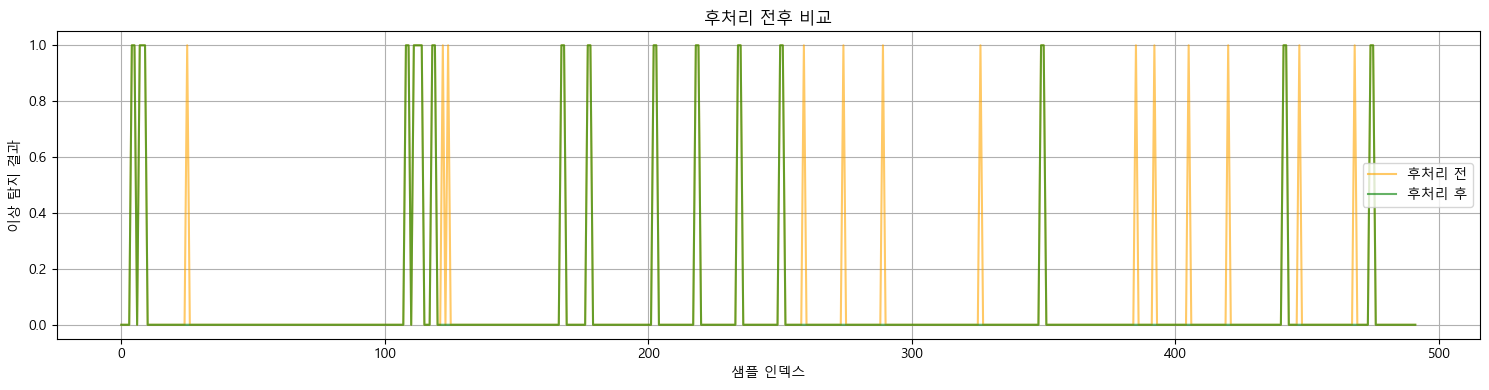

In [269]:
def compare_postprocessing(y_pred_bin, y_pred_post, title="후처리 전후 비교"):
    plt.figure(figsize=(15, 4))
    plt.plot(y_pred_bin, label='후처리 전', color='orange', alpha=0.6)
    plt.plot(y_pred_post, label='후처리 후', color='green', alpha=0.6)
    plt.title(title)
    plt.xlabel("샘플 인덱스")
    plt.ylabel("이상 탐지 결과")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

compare_postprocessing(y_pred_bin, y_pred_post)

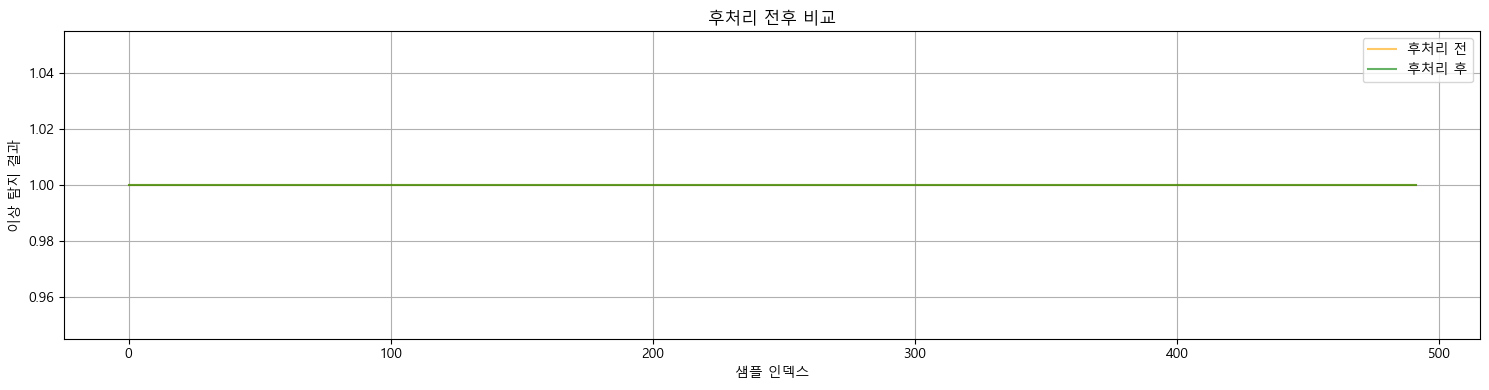

In [264]:
def compare_postprocessing(y_pred_bin, y_pred_post, title="후처리 전후 비교"):
    plt.figure(figsize=(15, 4))
    plt.plot(y_pred_bin, label='후처리 전', color='orange', alpha=0.6)
    plt.plot(y_pred_post, label='후처리 후', color='green', alpha=0.6)
    plt.title(title)
    plt.xlabel("샘플 인덱스")
    plt.ylabel("이상 탐지 결과")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

compare_postprocessing(y_seq, y_true_post)